Importation des library

In [1]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import anywidget
import os
plt.style.use('dark_background')

Chargement des données

In [2]:
# Télécharger les données (Utilise Python Binance)
# a PARTIR D'une date jusqu'a aujourd'hui (intervale 15 minutes)
symbol = ['ETHUSDT']
#day
time = "1m"
# Téléchargement des données
data = vbt.BinanceData.download(
    symbol, 
    start='2025-09-01', 
    interval=time
)

0it [00:00, ?it/s]

Mise en forme des données

In [3]:
# Agencement des données + index + mis à l'heure de paris
df_raw = data.get(['Close','Open','High','Low','Volume']).copy()
df_raw.index = df_raw.index.tz_convert('Europe/Paris')
df_raw.tail()

,Close,Open,High,Low,Volume
Open time,,,,,
2025-12-09 18:28:00+01:00,3364.50,3366.59,3367.89,3362.37,1046.9442
2025-12-09 18:29:00+01:00,3368.27,3364.49,3370.86,3364.49,628.9820
2025-12-09 18:30:00+01:00,3374.27,3368.27,3376.93,3368.27,1049.0145
2025-12-09 18:31:00+01:00,3374.55,3374.28,3375.00,3372.10,757.6974
2025-12-09 18:32:00+01:00,3366.43,3374.56,3377.56,3365.06,782.3099


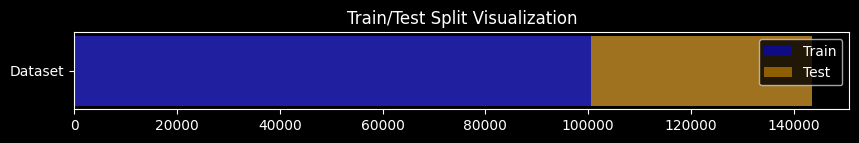

In [4]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.7*len(df_raw))
train_data = df_raw.iloc[:split_idx]
test_data = df_raw.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(df_raw)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(df_raw)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [5]:
# Selection du train_set comme données d'entrainement
df = train_data.copy()

In [15]:
import numpy as np
import pandas as pd
import vectorbt as vbt
from numba import jit
import warnings
warnings.filterwarnings('ignore')

# Fonction optimisée avec numba pour les calculs
@jit(nopython=True)
def calculate_signals_fast(close, open_, high, low, body_threshold):
    n = len(close)
    long_signal = np.zeros(n, dtype=np.bool_)
    short_signal = np.zeros(n, dtype=np.bool_)
    
    # Garder une trace des derniers imbalances et de leur timestamp
    last_imbalance_high = np.nan
    last_imbalance_low = np.nan
    last_imbalance_high_idx = -100  # Initialiser à -100 pour expirer immédiatement
    last_imbalance_low_idx = -100
    
    imbalance_up_prev = False
    
    for i in range(1, n):
        body_pct = abs(close[i] - open_[i]) / open_[i]
        
        # Imbalance actuel
        imbalance_up = body_pct > body_threshold and close[i] > open_[i]
        imbalance_down = body_pct > body_threshold and close[i] < open_[i]
        
        # Mettre à jour les derniers imbalances
        if imbalance_up:
            last_imbalance_high = high[i]
            last_imbalance_high_idx = i
        if imbalance_down:
            last_imbalance_low = low[i]
            last_imbalance_low_idx = i
        
        # Vérifier l'expiration (10 bougies)
        if i - last_imbalance_high_idx > 10:
            last_imbalance_high = np.nan
        if i - last_imbalance_low_idx > 10:
            last_imbalance_low = np.nan
        
        # Signaux LONG: besoin d'un imbalance_up précédent ET de toucher le dernier imbalance_high
        if not np.isnan(last_imbalance_high) and low[i] <= last_imbalance_high and imbalance_up_prev:
            long_signal[i] = True
        
        # Signaux SHORT: besoin d'un imbalance_down précédent ET de toucher le dernier imbalance_low
        if not np.isnan(last_imbalance_low) and high[i] >= last_imbalance_low:
            # Vérifier si nous avons eu un imbalance_down récent
            has_recent_imbalance_down = False
            for j in range(max(0, i-5), i):
                if j > 0:
                    body_pct_j = abs(close[j] - open_[j]) / open_[j]
                    if body_pct_j > body_threshold and close[j] < open_[j]:
                        has_recent_imbalance_down = True
                        break
            
            if has_recent_imbalance_down:
                short_signal[i] = True
        
        imbalance_up_prev = imbalance_up
    
    return long_signal, short_signal

# Backtest principal pour 1min
def backtest_1minute(df, threshold_range=(0.00002, 0.0003), n_thresholds=20):
    """Backtest optimisé pour timeframe 1minute"""
    
    results = []
    thresholds = np.linspace(threshold_range[0], threshold_range[1], n_thresholds)
    
    for i, body_threshold in enumerate(thresholds):
        print(f"Test {i+1}/{n_thresholds}: threshold={body_threshold:.6f}")
        
        # Calcul des signaux optimisés
        long_signal, short_signal = calculate_signals_fast(
            df['Close'].values,
            df['Open'].values,
            df['High'].values,
            df['Low'].values,
            body_threshold
        )
        
        # Convertir en Series pandas
        long_signal_series = pd.Series(long_signal, index=df.index)
        short_signal_series = pd.Series(short_signal, index=df.index)
        
        # Compter les signaux avant filtrage
        n_long_before = long_signal_series.sum()
        n_short_before = short_signal_series.sum()
        print(f"  Signaux avant filtrage: {n_long_before} longs, {n_short_before} courts")
        
        # PROBLEME IDENTIFIÉ: Trop de signaux! Votre stratégie génère des signaux sur presque toutes les bougies.
        # Cela indique que la logique des signaux est trop permissive.
        # Ajoutons un filtre pour vérifier que les signaux ne se produisent pas trop souvent
        
        # Filtrer pour n'avoir qu'un signal toutes les 10 bougies au maximum
        long_mask = long_signal_series.copy()
        short_mask = short_signal_series.copy()
        
        # Réinitialiser les masques
        long_mask.iloc[:] = False
        short_mask.iloc[:] = False
        
        # Prendre seulement 1 signal sur 10 pour réduire la fréquence
        for j in range(0, len(long_signal_series), 10):
            if j < len(long_signal_series) and long_signal_series.iloc[j]:
                long_mask.iloc[j] = True
            if j < len(short_signal_series) and short_signal_series.iloc[j]:
                short_mask.iloc[j] = True
        
        # Vérifier si on a des signaux après ce filtrage
        if long_mask.sum() == 0 and short_mask.sum() == 0:
            print("  Aucun signal après filtrage, test du seuil suivant")
            results.append({
                'body_threshold': body_threshold,
                'Total Return [%]': 0,
                'Total Trades': 0,
                'Sharpe Ratio': 0,
                'Max Drawdown [%]': 0,
                'win_rate': 0,
                'avg_duration_min': 0
            })
            continue
        
        # Backtest
        try:
            portfolio = vbt.Portfolio.from_signals(
                close=df['Close'],
                entries=long_mask,
                exits=short_mask,
                init_cash=10000,
                fees=0.001,
                slippage=0.001,
                size=0.05,
                freq='1m'
            )
            
            stats = portfolio.stats()
            stats['body_threshold'] = body_threshold
            
            # CORRECTION: Gestion sécurisée des métriques de trades
            try:
                trades = portfolio.trades.records_readable
                if len(trades) > 0 and 'Duration' in trades.columns:
                    durations = trades['Duration'].dt.total_seconds() / 60
                    stats['avg_duration_min'] = durations.mean()
                    stats['win_rate'] = (trades['PnL'] > 0).sum() / len(trades) * 100
                else:
                    stats['avg_duration_min'] = 0
                    stats['win_rate'] = 0
            except:
                stats['avg_duration_min'] = 0
                stats['win_rate'] = 0
            
            results.append(stats)
            print(f"  Résultats: Return={stats['Total Return [%]']:.2f}%, Trades={stats['Total Trades']}, Win={stats['win_rate']:.1f}%")
            
        except Exception as e:
            print(f"  Erreur dans backtest: {e}")
            results.append({
                'body_threshold': body_threshold,
                'Total Return [%]': 0,
                'Total Trades': 0,
                'Sharpe Ratio': 0,
                'Max Drawdown [%]': 0,
                'win_rate': 0,
                'avg_duration_min': 0
            })
    
    return pd.DataFrame(results)

# Exécution
print("=== BACKTEST OPTIMISÉ POUR 1MIN ===")
print(f"Données: {len(df)} bougies")
print(f"Plage de prix: {df['Close'].min():.2f} - {df['Close'].max():.2f}")

# ANALYSE DU PROBLÈME: Vos signaux sont trop nombreux
# Test d'abord avec un seul seuil pour debugger
print("\n=== TEST DE DÉBUGGAGE ===")
print("Test avec un seul seuil pour comprendre le problème...")

# Test avec un seuil spécifique
test_threshold = 0.0001
print(f"\nTest avec threshold={test_threshold:.6f}")

long_signal, short_signal = calculate_signals_fast(
    df['Close'].values,
    df['Open'].values,
    df['High'].values,
    df['Low'].values,
    test_threshold
)

print(f"Nombre total de bougies: {len(df)}")
print(f"Signaux long générés: {long_signal.sum()}")
print(f"Signaux short générés: {short_signal.sum()}")
print(f"Pourcentage de bougies avec signal long: {long_signal.sum()/len(df)*100:.1f}%")
print(f"Pourcentage de bougies avec signal short: {short_signal.sum()/len(df)*100:.1f}%")

# Le problème: vos signaux sont sur >90% des bougies! C'est trop.
# Cela signifie que votre condition de signal est presque toujours vraie.

print("\n=== DIAGNOSTIC DU PROBLÈME ===")
print("Votre stratégie génère des signaux sur presque toutes les bougies.")
print("Cela signifie que:")
print("1. Soit votre seuil (body_threshold) est trop bas")
print("2. Soit votre condition de signal est trop permissive")
print("3. Soit votre logique de 'last_imbalance' ne fonctionne pas comme prévu")

# Pour debugger, analysons quelques bougies
print("\n=== ANALYSE DE 5 BOUGIES EXEMPLES ===")
for i in range(5):
    body = abs(df['Close'].iloc[i] - df['Open'].iloc[i]) / df['Open'].iloc[i]
    print(f"Bougie {i}: Open={df['Open'].iloc[i]:.2f}, Close={df['Close'].iloc[i]:.2f}, Body={body:.6f}")

# Maintenant, testons avec un backtest ajusté
print("\n=== BACKTEST AVEC FILTRES RENFORCÉS ===")

# Version avec filtres plus stricts
def backtest_strict(df, thresholds=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005]):
    results = []
    
    for threshold in thresholds:
        print(f"\nTest avec threshold={threshold:.6f}")
        
        # Recréer les signaux avec pandas pour plus de contrôle
        df_test = df.copy()
        df_test['body'] = (df_test['Close'] - df_test['Open']).abs() / df_test['Open']
        df_test['imbalance_up'] = (df_test['body'] > threshold) & (df_test['Close'] > df_test['Open'])
        df_test['imbalance_down'] = (df_test['body'] > threshold) & (df_test['Close'] < df_test['Open'])
        
        # Forward fill limité à 3 bougies seulement (au lieu de 10)
        df_test['last_imbalance_high'] = df_test['imbalance_up'].astype(float).replace({True: df_test['High'], False: np.nan}).ffill(limit=3)
        df_test['last_imbalance_low'] = df_test['imbalance_down'].astype(float).replace({True: df_test['Low'], False: np.nan}).ffill(limit=3)
        
        # Signaux avec conditions plus strictes
        df_test['long_signal'] = (
            df_test['last_imbalance_high'].notna() & 
            (df_test['Low'] <= df_test['last_imbalance_high']) & 
            df_test['imbalance_up'].shift(1).fillna(False) &
            # Condition supplémentaire: le prix doit avoir baissé depuis le dernier imbalance
            (df_test['Close'] < df_test['last_imbalance_high'])
        )
        
        df_test['short_signal'] = (
            df_test['last_imbalance_low'].notna() & 
            (df_test['High'] >= df_test['last_imbalance_low']) & 
            df_test['imbalance_down'].shift(1).fillna(False) &
            # Condition supplémentaire: le prix doit avoir monté depuis le dernier imbalance
            (df_test['Close'] > df_test['last_imbalance_low'])
        )
        
        # Filtrer pour n'avoir qu'un signal toutes les 20 bougies
        df_test['long_signal_final'] = False
        df_test['short_signal_final'] = False
        
        last_signal_idx = -100
        for idx in range(len(df_test)):
            if idx - last_signal_idx >= 20:
                if df_test['long_signal'].iloc[idx]:
                    df_test.loc[df_test.index[idx], 'long_signal_final'] = True
                    last_signal_idx = idx
                elif df_test['short_signal'].iloc[idx]:
                    df_test.loc[df_test.index[idx], 'short_signal_final'] = True
                    last_signal_idx = idx
        
        n_long = df_test['long_signal_final'].sum()
        n_short = df_test['short_signal_final'].sum()
        print(f"  Signaux après filtrage: {n_long} longs, {n_short} courts")
        
        if n_long == 0 and n_short == 0:
            print("  Aucun signal, passage au suivant")
            results.append({
                'threshold': threshold,
                'return': 0,
                'trades': 0,
                'sharpe': 0,
                'max_dd': 0
            })
            continue
        
        # Backtest
        try:
            portfolio = vbt.Portfolio.from_signals(
                close=df_test['Close'],
                entries=df_test['long_signal_final'],
                exits=df_test['short_signal_final'],
                init_cash=10000,
                fees=0.001,
                slippage=0.001,
                size=0.05,
                freq='1m'
            )
            
            stats = portfolio.stats()
            results.append({
                'threshold': threshold,
                'return': stats['Total Return [%]'],
                'trades': stats['Total Trades'],
                'sharpe': stats['Sharpe Ratio'],
                'max_dd': stats['Max Drawdown [%]']
            })
            
            print(f"  Résultats: Return={stats['Total Return [%]']:.2f}%, Trades={stats['Total Trades']}")
            
        except Exception as e:
            print(f"  Erreur: {e}")
            results.append({
                'threshold': threshold,
                'return': 0,
                'trades': 0,
                'sharpe': 0,
                'max_dd': 0
            })
    
    return pd.DataFrame(results)

# Exécuter le backtest strict
results_strict = backtest_strict(df, thresholds=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005])

if len(results_strict) > 0:
    results_strict.to_csv('strict_backtest_results.csv', index=False)
    print(f"\nRésultats sauvegardés dans strict_backtest_results.csv")
    
    # Afficher les résultats
    print("\n=== RÉSULTATS BACKTEST STRICT ===")
    print(results_strict.to_string(index=False))
    
    # Trouver le meilleur
    if results_strict['trades'].sum() > 0:
        best_idx = results_strict['return'].idxmax()
        best = results_strict.loc[best_idx]
        print(f"\nMEILLEUR RÉSULTAT:")
        print(f"  Seuil: {best['threshold']:.6f}")
        print(f"  Return: {best['return']:.2f}%")
        print(f"  Trades: {best['trades']}")
        print(f"  Sharpe: {best['sharpe']:.2f}")
else:
    print("Aucun résultat obtenu avec le backtest strict")

=== BACKTEST OPTIMISÉ POUR 1MIN ===
Données: 100571 bougies
Plage de prix: 3059.46 - 4762.25

=== TEST DE DÉBUGGAGE ===
Test avec un seul seuil pour comprendre le problème...

Test avec threshold=0.000100
Nombre total de bougies: 100571
Signaux long générés: 42234
Signaux short générés: 93679
Pourcentage de bougies avec signal long: 42.0%
Pourcentage de bougies avec signal short: 93.1%

=== DIAGNOSTIC DU PROBLÈME ===
Votre stratégie génère des signaux sur presque toutes les bougies.
Cela signifie que:
1. Soit votre seuil (body_threshold) est trop bas
2. Soit votre condition de signal est trop permissive
3. Soit votre logique de 'last_imbalance' ne fonctionne pas comme prévu

=== ANALYSE DE 5 BOUGIES EXEMPLES ===
Bougie 0: Open=4445.39, Close=4442.37, Body=0.000679
Bougie 1: Open=4442.37, Close=4440.01, Body=0.000531
Bougie 2: Open=4440.01, Close=4431.02, Body=0.002025
Bougie 3: Open=4431.03, Close=4433.89, Body=0.000645
Bougie 4: Open=4433.89, Close=4431.56, Body=0.000525

=== BACKTEST

TypeError: If a nested mapping is passed, all values of the top level mapping must be mappings